In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from xopt import creator, fitness_with_constraints, vocs_tools

from deap import base, tools
import array
import random
import numpy as np

In [3]:
NAME = 'TNK'
BOUND_LOW, BOUND_UP = [0.0, 0.0], [3.14159, 3.14159]  
WEIGHTS = [-1, -1] # Minimize
NDIM = 2
N_CONSTRAINTS = 2

def TNK(individual):    
    x1=individual[0]
    x2=individual[1]
    objectives =  (x1, x2)
    constraints = (x1**2+x2**2-1.0 - 0.1*np.cos(16*np.arctan2(x1, x2)), 0.5-(x1-0.5)**2-(x2-0.5)**2 )
    return objectives, constraints

F = TNK
X_RANGE = [0, 1.4]
Y_RANGE = [0, 1.4]




VOCS = {
    'name':'TNK_test',
    
    'variables': {
        'x1':[0, 3.14159],
        'x2':[0, 3.14159]
    },
    'objectives':{
        'y1':'MINIMIZE',
        'y2':'MINIMIZE'
        
    },
    'constraints':{
        'c1': ['GREATER_THAN', 0],
        'c2': ['GREATER_THAN', 0]
        
    },
    'constants':{'a':'dummy_constant'},
    'linked_variables':{'x9':'x1'}
    
    
}
vocs_tools.save_vocs(VOCS)

TNK_test.json written


In [5]:
def evaluate_TNK(inputs):
    info = {'some':'info', 'about':['the', 'run']}
    
    ind = [inputs['x1'], inputs['x2']]
    objectives, constraints = TNK(ind)
    
    outputs = {'y1':objectives[0], 'y2':objectives[1], 'c1':constraints[0], 'c2':constraints[1]}
    
    # Add this for testing
    outputs.update(info)
    
    return outputs
evaluate_TNK({'x1':2, 'x2':1})
    

{'y1': 2,
 'y2': 1,
 'c1': 3.957802752,
 'c2': -2.0,
 'some': 'info',
 'about': ['the', 'run']}

In [6]:
VAR, OBJ, CON = VOCS['variables'], VOCS['objectives'], VOCS['constraints']
len(CON)

2

In [7]:
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [8]:


def cnsga_toolbox(vocs, selection='auto', verbose=False):
    """
    Creates a DEAP toolbox from VOCS dict
    """
    
    var, obj, con = vocs['variables'], vocs['objectives'], vocs['constraints']
    n_var = len(var)
    n_obj = len(obj)
    n_con = len(con)
    
    var_labels = vocs_tools.skeys(var)
    obj_labels = vocs_tools.skeys(obj)
    
    bound_low = vocs_tools.var_mins(var)
    bound_up = vocs_tools.var_maxs(var)
    
    weights = vocs_tools.weight_list(obj)
    
    # Create MyFitness 
    if 'MyFitness' in dir(creator):
        del creator.MyFitness
        if verbose:
            print('Warning: Redefining creator.MyFitness')
    
    if n_con == 0:
        # Normal Fitness class
        creator.create('MyFitness', base.Fitness, weights=weights, labels=obj_labels)
    else:
        # Fitness with Constraints
        creator.create('MyFitness', fitness_with_constraints.FitnessWithConstraints, 
                   weights=weights, n_constraints=n_con, labels=obj_labels) 
    
    # Create Individual
    creator.create('Individual', array.array, typecode='d', fitness=creator.MyFitness, 
                   labels=var_labels)    
    
    if 'Individual' in dir(creator):
        del creator.MyFitness
        if verbose:
            print('Warning in cnsga_toolbox: Redefining creator.Individual')
      
    # Make toolbox
    toolbox = base.Toolbox()    
    
    # Register indivitual and population creation routines
    toolbox.register('attr_float', uniform, bound_low, bound_up)
    toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.attr_float)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)        
    
    # Register mate and mutate functions
    toolbox.register('mate', tools.cxSimulatedBinaryBounded, low=bound_low, up=bound_up, eta=20.0)
    toolbox.register('mutate', tools.mutPolynomialBounded, low=bound_low, up=bound_up, eta=20.0, indpb=1.0/n_var)
    
    # Register NSGA selection algorithm.
    # NSGA-III should be better for 3 or more objectives
    if selection == 'auto':
        if len(obj) <= 2:
            selection = 'nsga2'
        else:
            selection='nsga3'

    if selection == 'nsga2':
        toolbox.register('select', tools.selNSGA2)
    elif selection == 'nsga3':
        toolbox.register('select', tools.selNSGA3)
    else:
        print('Error: invalid selection algorithm', selection)
        raise
    
    
    if verbose:
        print(f'Created toolbox with {n_var} variables, {n_con} constraints, and {n_obj} objectives.')
        print(f'    Using slection algorithm: {selection}')
    return toolbox
    
    
    

In [9]:
TOOLBOX = cnsga_toolbox(VOCS, verbose=True)

Warning in cnsga_toolbox: Redefining creator.Individual
Created toolbox with 2 variables, 2 constraints, and 2 objectives.
    Using slection algorithm: nsga2


# Test usage

In [10]:
from xopt.cnsga import cnsga

In [11]:
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor
from concurrent.futures import ThreadPoolExecutor as PoolExecutor

executor = PoolExecutor()

In [ ]:
from dask.distributed import Client
executor = Client()
executor

In [ ]:
# Wrap evaluate to return the input and output
def EVALUATE(vec):
    #sleep_time = random.random() *2
    #time.sleep(sleep_time)
    fit = F(vec)
    return vec, fit

In [ ]:
def inputs_from_vec(vec, vocs=None):
    """
    Forms labeled inputs from vector using vocs. If no vocs is given, labels are created in the form:
        variable_{i}

    """
    if not vocs:
        vkeys = [f'variable_{i}' for i in range(len(vec))]
        return dict(zip(keys, vec))
    
    # labeled inputs -> labeled outputs evaluate_f
    vkeys =  skeys(vocs['variables'])
    inputs = dict(zip(vkeys, vec))
    
    # Constants    
    if 'constants' in vocs:
        inputs.update(vocs['constants'])
        
    # Handle linked variables
    if 'linked_variables' in vocs:
        for k, v in vocs['linked_variables'].items():
            inputs[k] = inputs[v]    
    
    return inputs

In [39]:
def cnsga_evaluate(vec, evaluate_f=None, vocs=None, include_inputs_and_outputs=True, verbose=False):
    """
    Evaluation function wrapper for use with cngsa. Returns dict with:
        'vec', 'obj', 'con'
    
    If a vocs is given, the function evaluate_f is assumed to have labeled inputs and outputs,
    and vocs will be used to form the output above. If include_inputs_and_outputs, these will be added 
    to the result. 
    
    Otherwise, evaluate_f should return pure numbers as:
        vec -> (objectives, constraints)

    This function will be evaulated by a worker. 
    
    Any exceptions will be caught, and this will return:
        0 for all objectives
        -666.0 for all constraints

    """
    
    result = {}
    
    # Make this 
    try:
        
        if vocs:
            # labeled inputs -> labeled outputs evaluate_f
            inputs = vocs_tools.inputs_from_vec(vec, vocs=vocs)
    
            # Evaluation
            outputs = evaluate_f(inputs)
        
            obj_eval = vocs_tools.evaluate_objectives(vocs['objectives'], outputs)
            con_eval = vocs_tools.evaluate_constraints(vocs['constraints'], outputs)
            
            # Add these to result
            if include_inputs_and_outputs:
                result['inputs'] = inputs
                result['outputs'] = outputs
        
        else:
        # Pure number function
            obj_eval, con_eval = evaluate_f(vec)
        
    except Exception as ex:
        if verbose:
            print('Exception caught in cnsga_evaluate:', ex)

        # Dummy output
        obj_eval = [0.0]*len(vocs['objectives'])
        con_eval = [-666.0]*len(vocs['constraints'])
    
    result['vec'] = vec
    result['obj'] = obj_eval
    result['con'] = con_eval

    return result

cnsga_evaluate([1,.1], vocs=VOCS, evaluate_f=evaluate_TNK)    
    

{'inputs': {'x1': 1, 'x2': 0.1, 'a': 'dummy_constant', 'x9': 1},
 'outputs': {'y1': 1,
  'y2': 0.1,
  'c1': 0.01238998372053216,
  'c2': 0.08999999999999997,
  'some': 'info',
  'about': ['the', 'run']},
 'vec': [1, 0.1],
 'obj': [1, 0.1],
 'con': [0.01238998372053216, 0.08999999999999997]}

In [40]:
def crash(inputs):
    inputs = 1/0
cnsga_evaluate([1,.1], vocs=VOCS, evaluate_f=crash, verbose=True)        

Exception caught in cnsga_evaluate: division by zero


{'vec': [1, 0.1], 'obj': [0.0, 0.0], 'con': [-666.0, -666.0]}

In [35]:
vocs_tools.random_inputs(VOCS, 10)

{'x1': array([3.00255139, 2.72840182, 0.44932331, 0.46881555, 0.57584562,
        0.30057676, 1.23617971, 1.48650211, 1.53000581, 1.6508795 ]),
 'x2': array([1.83592836, 2.60138122, 0.45596838, 0.49124443, 0.11108919,
        2.42928918, 1.03832257, 0.80333756, 2.74336943, 1.44354263]),
 'a': 'dummy_constant',
 'x9': array([3.00255139, 2.72840182, 0.44932331, 0.46881555, 0.57584562,
        0.30057676, 1.23617971, 1.48650211, 1.53000581, 1.6508795 ])}

In [15]:
#TOOLBOX.register('evaluate', evaluator, vocs=VOCS, f=evaluate_TNK)
TOOLBOX.register('evaluate', cnsga_evaluate, evaluate_f=TNK)

In [16]:
TOOLBOX.evaluate([1,1])

{'vec': [1, 1], 'obj': (1, 1), 'con': (0.9, 0.0)}

In [17]:
vocs_tools.evaluate_constraints(VOCS['constraints'], 
                                {'y1': 1, 'y2': 0.1, 'c1': 0.01238998372053216, 'c2': 0.08999999999999997})

[0.01238998372053216, 0.08999999999999997]

In [18]:
INPUTS = vocs_tools.random_inputs(VOCS,64)

In [19]:
import array
array.array('d', np.array([1,2]))

array('d', [1.0, 2.0])

In [ ]:
d

In [20]:
def population_init(data, vocs):
    """
    Initialize a population from keyed data and vocs.
    """
    # Get keys to look for in data
    varkeys = vocs_tools.skeys(vocs['variables'])
    
    # extract vecs
    vecs = np.array([data[k] for k in varkeys]).T 
    
    # Form individuals
    pop = []
    for vec in vecs:
        ind = creator.Individual(vec)
        pop.append(ind)
    
    # TODO
    # Extract relevant output to form fitness
    #objkeys = vocs_tools.skeys(vocs['objectives'])
    #conkeys = vocs_tools.skeys(vocs['constraints'])
    #np.array([data[k] for k in skeys(objective_dict)])       
    
    return pop
    
population_init(INPUTS, VOCS)

[Individual('d', [1.5362536769138877, 2.2912024611421846]),
 Individual('d', [1.9007636099248888, 1.8650931051367343]),
 Individual('d', [1.9210113836194627, 1.2537303967740918]),
 Individual('d', [2.6606893573224233, 2.8417830837361757]),
 Individual('d', [1.8219247104939131, 2.045604940689235]),
 Individual('d', [1.3735503287491415, 1.0495949975420418]),
 Individual('d', [2.2114200815551293, 2.9097571924379526]),
 Individual('d', [2.3633054020847504, 0.8012417946946429]),
 Individual('d', [2.963797364116796, 1.7182965955427285]),
 Individual('d', [2.578735126563337, 0.9511015297495895]),
 Individual('d', [2.5872849524439143, 2.343697350003944]),
 Individual('d', [2.366110540341852, 1.9272909319401883]),
 Individual('d', [0.30331847656426936, 0.13359540361621738]),
 Individual('d', [3.120498770564387, 1.451341589521077]),
 Individual('d', [1.8895095371713424, 1.3959044448956086]),
 Individual('d', [1.9285116799770732, 1.8019307342901756]),
 Individual('d', [2.505777588788074, 2.708148

In [26]:
TOOLBOX.register('evaluate', cnsga_evaluate, vocs=VOCS, evaluate_f=evaluate_TNK)

pop = cnsga(executor, toolbox=TOOLBOX, max_generations = 40, population_size=64) 
#pop = cnsga(executor, vocs=VOCS, evaluate_f=evaluate_TNK, max_generations = 40, population_size=64) 

Generation 0 completed
Generation 1 completed
Generation 2 completed
Generation 3 completed
Generation 4 completed
Generation 5 completed
Generation 6 completed
Generation 7 completed
Generation 8 completed
Generation 9 completed
Generation 10 completed
Generation 11 completed
Generation 12 completed
Generation 13 completed
Generation 14 completed
Generation 15 completed
Generation 16 completed
Generation 17 completed
Generation 18 completed
Generation 19 completed
Generation 20 completed
Generation 21 completed
Generation 22 completed
Generation 23 completed
Generation 24 completed
Generation 25 completed
Generation 26 completed
Generation 27 completed
Generation 28 completed
Generation 29 completed
Generation 30 completed
Generation 31 completed
Generation 32 completed
Generation 33 completed
Generation 34 completed
Generation 35 completed
Generation 36 completed
Generation 37 completed
Generation 38 completed
Generation 39 completed


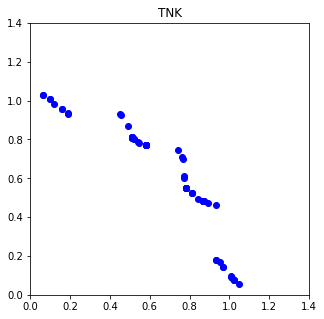

In [27]:
import matplotlib.pyplot as plt

def plot_pop(pop):
    fig, ax = plt.subplots(figsize=(5,5))

    front = np.array([ind.fitness.values for ind in pop])
    ax.scatter(front[:,0], front[:,1], color='blue')
    ax.set_xlim(X_RANGE)
    ax.set_ylim(Y_RANGE)
    ax.set_aspect('auto')
    ax.set_title(NAME)
plot_pop(pop)